In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import matplotlib.pyplot as plt
import re
import json

from PIL import Image

In [ ]:
!pip install pycocotools
import random
from pycocotools.coco import COCO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/GNLP/val2017.zip'

In [ ]:
!ls "{zip_path}"

'/content/drive/My Drive/GNLP/val2017.zip'


In [ ]:
# Create a directory to extract to
!mkdir -p /content/coco

In [ ]:
!unzip "{zip_path}" -d /content/coco

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/val2017/000000212226.jpg  
 extracting: /content/coco/val2017/000000231527.jpg  
 extracting: /content/coco/val2017/000000578922.jpg  
 extracting: /content/coco/val2017/000000062808.jpg  
 extracting: /content/coco/val2017/000000119038.jpg  
 extracting: /content/coco/val2017/000000114871.jpg  
 extracting: /content/coco/val2017/000000463918.jpg  
 extracting: /content/coco/val2017/000000365745.jpg  
 extracting: /content/coco/val2017/000000320425.jpg  
 extracting: /content/coco/val2017/000000481404.jpg  
 extracting: /content/coco/val2017/000000314294.jpg  
 extracting: /content/coco/val2017/000000335328.jpg  
 extracting: /content/coco/val2017/000000513688.jpg  
 extracting: /content/coco/val2017/000000158548.jpg  
 extracting: /content/coco/val2017/000000132116.jpg  
 extracting: /content/coco/val2017/000000415238.jpg  
 extracting: /content/coco/val2017/000000321333.jpg  
 extracting: /content/coco/val2

In [ ]:
coco_folder = "/content/coco/val2017"
# Load the CSV
csv_path = "vlm_flip_symmetry_results.csv"
df = pd.read_csv(csv_path)

# Extract the 'Image' column as a list
image_files = df["Image"].tolist()

In [ ]:
len(image_files)

500

In [ ]:
image_files[0]

'000000009483.jpg'

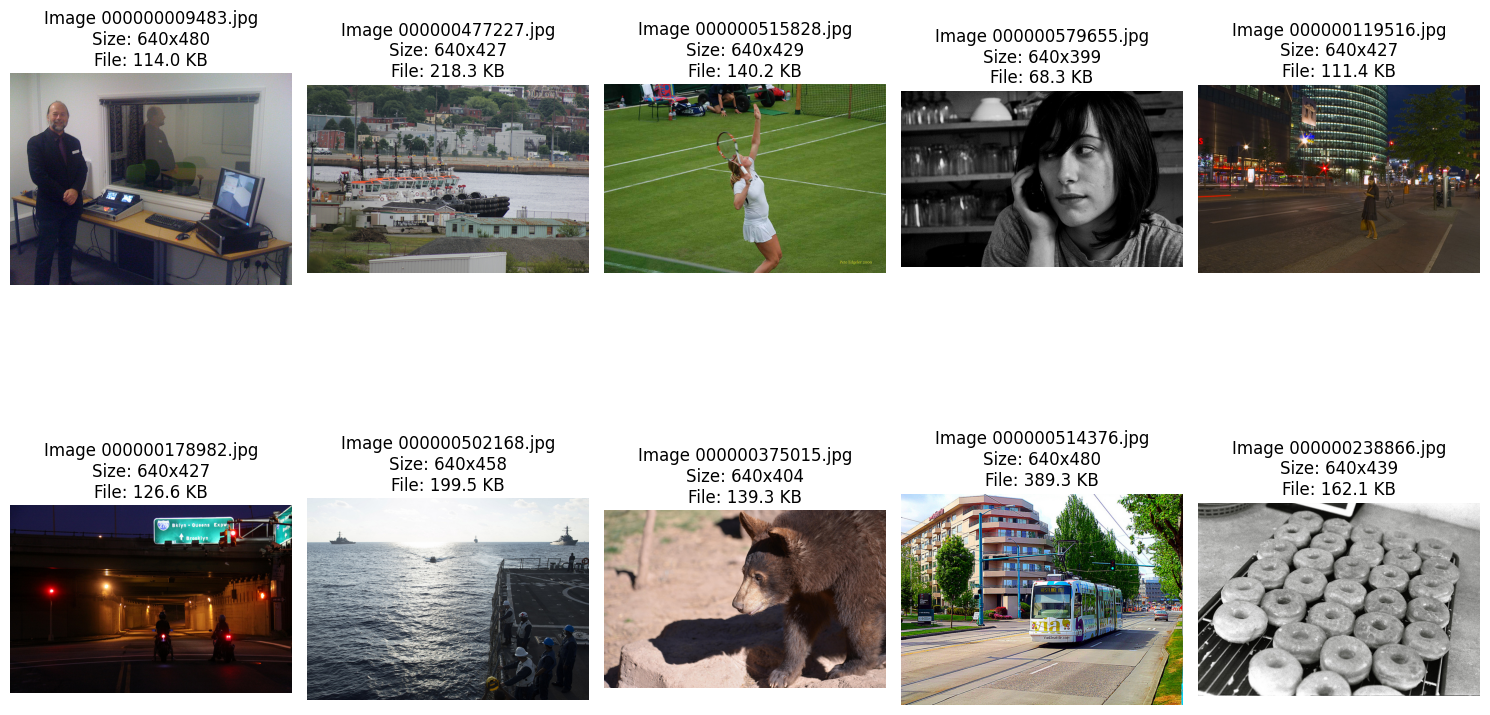

In [ ]:
# Plot first 10 images
fig = plt.figure(figsize=(15, 10))

for i, img_file in enumerate(image_files[:10]):
    img_path = os.path.join(coco_folder, img_file)

    # Get file size in KB
    file_size_kb = os.path.getsize(img_path) / 1024

    img = Image.open(img_path)
    width, height = img.size
    img_array = np.array(img)

    # Create subplot
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img)
    ax.set_title(f"Image {img_file}\nSize: {width}x{height}\nFile: {file_size_kb:.1f} KB")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def plot_original_and_flipped(img_file, coco_folder):
    img_path = os.path.join(coco_folder, img_file)

    # Load original and flipped image
    img = Image.open(img_path).convert("RGB")
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Metadata
    width, height = img.size
    file_size_kb = os.path.getsize(img_path) / 1024

    # Convert to arrays
    img_array = np.array(img)
    img_flipped_array = np.array(img_flipped)

    # Plot side-by-side with minimal spacing
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.subplots_adjust(wspace=0.05)  # reduce space between plots

    axs[0].imshow(img_array)
    axs[0].set_title(f"Original\n{img_file}\n{width}x{height}, {file_size_kb:.1f} KB")
    axs[0].axis("off")

    axs[1].imshow(img_flipped_array)
    axs[1].set_title("Flipped (Left ↔ Right)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

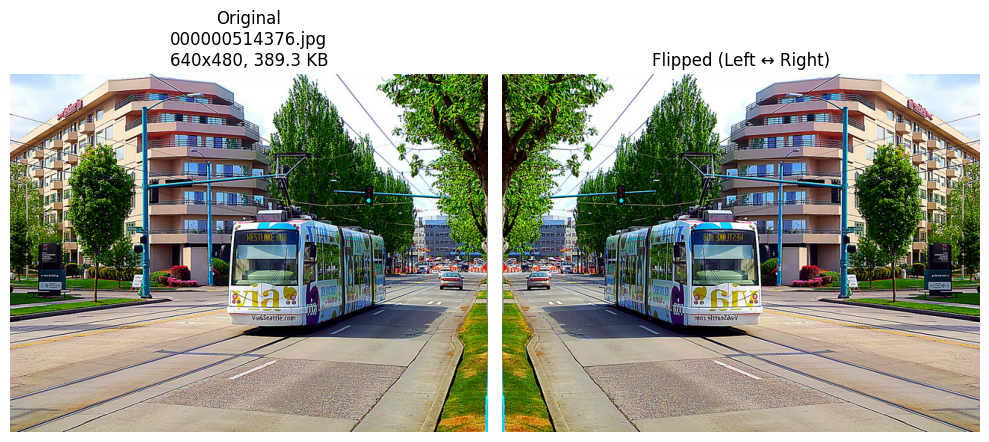

In [ ]:
plot_original_and_flipped(image_files[8], coco_folder)

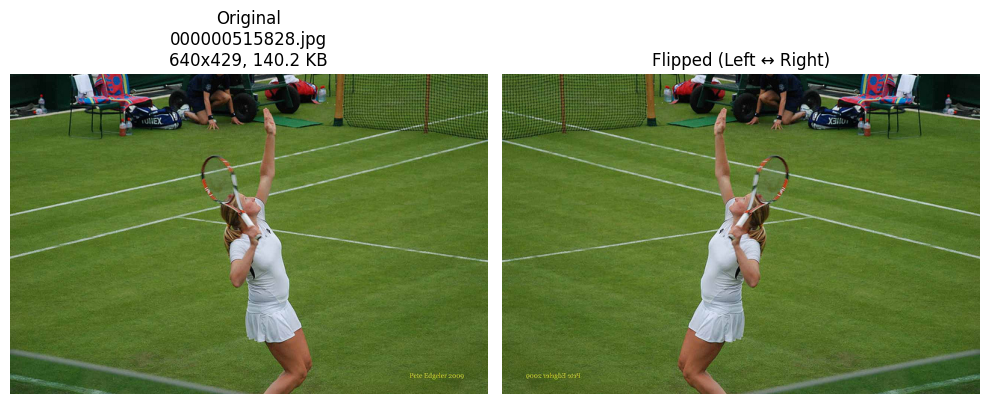

In [ ]:
plot_original_and_flipped(image_files[2], coco_folder)

## Llava downstream tasks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_symmetry_csv_objects(csv_path):
    # Load CSV
    df = pd.read_csv(csv_path)

    # Basic summary
    print("Summary Statistics:")
    print(df.describe())

    # Check for expected columns
    expected = ['#Objects_Original', '#Objects_Flipped', '#Shared', 'Jaccard']
    missing = [col for col in expected if col not in df.columns]
    if missing:
        print(f"\nWarning: Missing expected columns: {missing}")

    # Add a difference column (optional)
    if 'original_count' in df.columns and 'flipped_count' in df.columns:
        df['count_diff'] = (df['original_count'] - df['flipped_count']).abs()

    # Histograms
    plt.figure(figsize=(12, 5))
    if 'jaccard_distance' in df.columns:
        plt.subplot(1, 2, 1)
        sns.histplot(df['jaccard_distance'], bins=20, kde=True)
        plt.title("Distribution of Jaccard Distance")
        plt.xlabel("Jaccard Distance")

    if 'count_diff' in df.columns:
        plt.subplot(1, 2, 2)
        sns.histplot(df['count_diff'], bins=20, kde=True)
        plt.title("Distribution of Count Difference")
        plt.xlabel("|Original - Flipped|")

    plt.tight_layout()
    plt.show()

    # Scatter Plot
    if 'count_diff' in df.columns and 'jaccard_distance' in df.columns:
        plt.figure(figsize=(6, 5))
        sns.scatterplot(data=df, x='count_diff', y='jaccard_distance')
        plt.title("Count Difference vs Jaccard Distance")
        plt.xlabel("Absolute Count Difference")
        plt.ylabel("Jaccard Distance")
        plt.grid(True)
        plt.show()

    return df

Summary Statistics:
       #Objects_Original  #Objects_Flipped     #Shared     Jaccard
count         500.000000        500.000000  500.000000  500.000000
mean            7.068000          6.806000    3.638000    0.469892
std             4.999336          4.693444    2.416326    0.308603
min             1.000000          1.000000    0.000000    0.000000
25%             4.000000          4.000000    2.000000    0.200000
50%             5.000000          5.000000    3.000000    0.425000
75%             9.000000          9.000000    5.000000    0.714000
max            38.000000         31.000000   14.000000    1.000000


<Figure size 1200x500 with 0 Axes>


Correlation Matrix:
                   #Objects_Original  #Objects_Flipped   #Shared   Jaccard  \
#Objects_Original           1.000000          0.479357  0.472518 -0.324884   
#Objects_Flipped            0.479357          1.000000  0.550597 -0.268460   
#Shared                     0.472518          0.550597  1.000000  0.380977   
Jaccard                    -0.324884         -0.268460  0.380977  1.000000   
ExactMatch                 -0.280883         -0.276457 -0.003081  0.699518   

                   ExactMatch  
#Objects_Original   -0.280883  
#Objects_Flipped    -0.276457  
#Shared             -0.003081  
Jaccard              0.699518  
ExactMatch           1.000000  


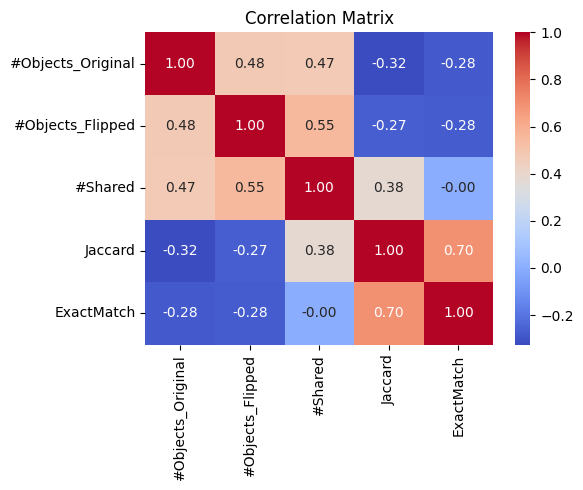

#Objects_Original  #Objects_Flipped  #Shared  Jaccard  ExactMatch  \
0                    8                 6        4    0.400       False   
1                   10                11        8    0.615       False   
2                   18                 7        2    0.087       False   
3                    7                 6        5    0.625       False   
4                    7                 7        4    0.400       False   
..                 ...               ...      ...      ...         ...   
495                  3                 3        3    1.000        True   
496                 22                18        9    0.290       False   
497                 19                 9        6    0.273       False   
498                  6                 5        5    0.833       False   
499                  4                 4        4    1.000        True   

                                      MissingInFlipped  \
0               ['man', 'computer', 'chairs', 'table']   
1                     ['traffic lights', 'and houses']   
2    ['hair', 'volleyball', 'racket', 'fan', 'pen',...   
3                                    ['knife', 'bowl']   
4               ['pedestrian', 'lantern', 'crosswalk']   
..                                                 ...   
495                                                 []   
496  ['bowl', 'microwave', 'bracelet', 'sink', 'din...   
497  ['park bench back', 'park bench armrest armres...   
498                                         ['people']   
499                                                 []   

                                        ExtraInFlipped  \
0                                    ['chair', 'shoe']   
1                       ['and city', 'houses', 'dock']   
2    ['backpack', 'tennis racket', 'tennis ball', '...   
3                                           ['bottle']   
4                          ['bus', 'buildings', 'bag']   
..                                                 ...   
495                                                 []   
496  ['cutting board', 'bottle', 'c', 'tank top', '...   
497                    ['and park', 'fence', 'leaves']   
498                                                 []   
499                                                 []   

                                           OriginalSet  \
0    {'window', 'keyboard', 'computer', 'monitor', ...   
1    {'trees', 'cars', 'grass', 'and houses', 'truc...   
2    {'hair', 'volleyball', 'racket', 'fan', 'pen',...   
3    {'pot', 'bowl', 'vase', 'knife', 'jar', 'cup',...   
4    {'trees', 'pedestrian', 'crosswalk', 'car', 't...   
..                                                 ...   
495                    {'clock', 'window', 'building'}   
496  {'microwave', 'tie', 'man', 'cake', 'cup', 'sh...   
497  {'park bench back', 'park bench armrest seat',...   
498  {'skateboard', 'people', 'building', 'shirt', ...   
499                   {'skis', 'trees', 'man', 'snow'}   

                                            FlippedSet             Image  
0    {'window', 'keyboard', 'shoe', 'monitor', 'cha...  000000009483.jpg  
1    {'trees', 'and city', 'cars', 'grass', 'trucks...  000000477227.jpg  
2    {'backpack', 'tennis racket', 'tennis ball', '...  000000515828.jpg  
3     {'pot', 'vase', 'jar', 'bottle', 'cup', 'glass'}  000000579655.jpg  
4    {'trees', 'buildings', 'bag', 'car', 'traffic ...  000000119516.jpg  
..                                                 ...               ...  
495                    {'clock', 'window', 'building'}  000000331317.jpg  
496  {'cup', 'glass', 'cutting board', 'bottle', 'f...  000000144003.jpg  
497  {'grass', 'leaves', 'person', 'tree', 'and par...  000000197870.jpg  
498  {'skateboard', 'building', 'shirt', 'jeans', '...  000000128699.jpg  
499                   {'skis', 'trees', 'man', 'snow'}  000000280779.jpg  

[500 rows x 10 columns]

In [ ]:
csv_path = 'vlm_flip_symmetry_results.csv'
analyze_symmetry_csv_objects(csv_path)

In [ ]:
def analyze_accuracy_symmetry(csv_path):
    df = pd.read_csv(csv_path)

    # Check required columns
    required_cols = ['Normal', 'Symmetrical']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        print(f"⚠️ Missing columns: {missing}")
        return None

    # Compute accuracy and count
    print("Accuracy Statistics:")
    stats = df[required_cols].agg(['mean', 'count']).T
    stats.columns = ['Accuracy (Mean)', 'Total Samples']
    print(stats)

    # Bar plot without error bars
    plt.figure(figsize=(6, 4))
    plt.bar(stats.index, stats['Accuracy (Mean)'], color=['steelblue', 'salmon'])
    plt.ylim(0, 1.05)
    plt.title("Accuracy on Normal vs. Symmetrical Images")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    return stats



📋 Accuracy Statistics:
             Accuracy (Mean)  Total Samples
Normal                 0.202          500.0
Symmetrical            1.000          500.0


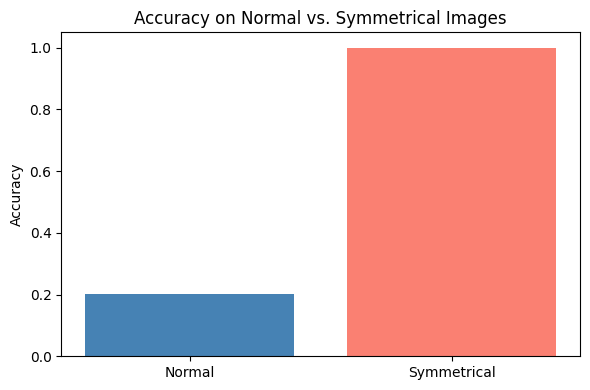

Accuracy (Mean)  Total Samples
Normal                 0.202          500.0
Symmetrical            1.000          500.0

In [ ]:
csv_path_2 = 'vlm_symmetry_results_part2.csv'
analyze_accuracy_symmetry(csv_path_2)

## Egocentric vs Viewer Centric plots

In [ ]:
from collections import Counter
# Paths
annotation_file = 'instances_val2017.json'
image_dir = 'coco/val2017'

# Load COCO
coco = COCO(annotation_file)

# Map: file_name → image_id
file_name_to_id = {
    img["file_name"]: img["id"]
    for img in coco.dataset["images"]
}

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [ ]:
# Run from JSON
with open("sampled_lr_pairs_1000.json", "r") as f:
    sampled_pairs = json.load(f)

In [ ]:
sampled_pairs[0]

{'image_id': 181796,
 'file_name': '000000181796.jpg',
 'left_object': 'wine glass',
 'right_object': 'fork'}

In [ ]:
from PIL import Image, ImageDraw
import os

def plot_sampled_pair_with_boxes(index=0):
    entry = sampled_pairs[index]
    file_name = entry["file_name"]
    left_name = entry["left_object"]
    right_name = entry["right_object"]
    img_path = os.path.join(coco_folder, file_name)

    # Load and flip image
    img = Image.open(img_path).convert("RGB")
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
    draw = ImageDraw.Draw(img_flipped)

    # Get annotations
    image_id = file_name_to_id[file_name]
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # Draw bounding boxes for left and right objects
    for ann in anns:
        name = coco.loadCats(ann["category_id"])[0]["name"]
        if name == left_name or name == right_name:
            x, y, w, h = ann["bbox"]
            flipped_x = img_flipped.width - x - w
            box = [flipped_x, y, flipped_x + w, y + h]
            color = "green" if name == left_name else "red"
            draw.rectangle(box, outline=color, width=3)
            draw.text((box[0], box[1] - 10), name, fill=color)

    # Image metadata
    width, height = img_flipped.size
    file_size_kb = os.path.getsize(img_path) / 1024

    # Plot image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_flipped)
    plt.title(f"{file_name}\n{left_name} vs {right_name}\n{width}x{height}, {file_size_kb:.1f} KB")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


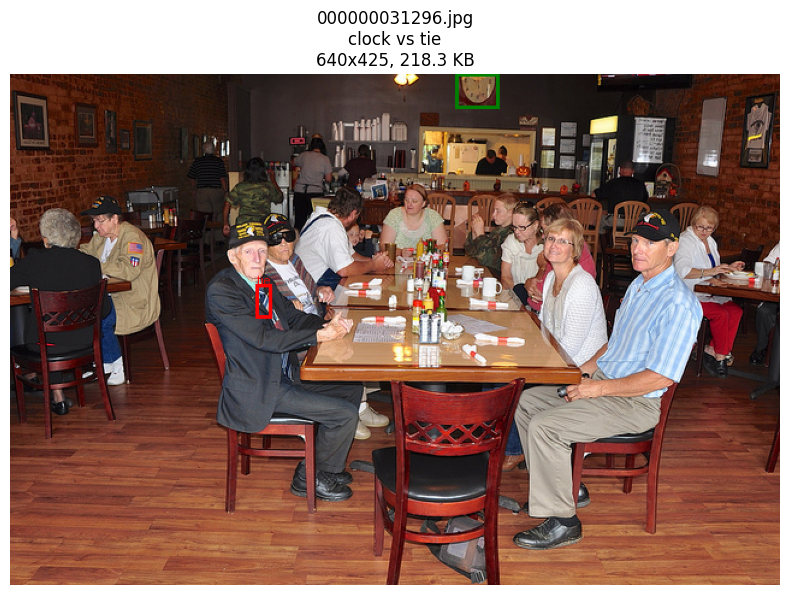

In [ ]:
plot_sampled_pair_with_boxes(10)

In [ ]:
def plot_accuracy_comparison(viewer_df, ego_df):
    data = {
        'Viewer': [viewer_df['Original'].mean(), viewer_df['Flipped'].mean()],
        'Ego': [ego_df['Original'].mean(), ego_df['Flipped'].mean()]
    }
    df = pd.DataFrame(data, index=['Original', 'Flipped'])

    df.plot(kind='bar')
    plt.title('Accuracy Comparison (Original vs. Flipped)')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.legend(title="Perspective")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns

def plot_heatmap(df, title):
    matrix = pd.crosstab(df['Original'], df['Flipped'], normalize='all')
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title(title)
    plt.xlabel('Flipped')
    plt.ylabel('Original')
    plt.show()

In [ ]:
def symmetry_bias_analysis(df, label):
    both_correct = ((df['Original'] == True) & (df['Flipped'] == True)).sum()
    original_only = ((df['Original'] == True) & (df['Flipped'] == False)).sum()
    flipped_only = ((df['Original'] == False) & (df['Flipped'] == True)).sum()
    both_wrong = ((df['Original'] == False) & (df['Flipped'] == False)).sum()

    # Print counts
    print(f"--- {label} ---")
    print(f"Both correct (A): {both_correct}")
    print(f"Original correct only (B): {original_only}")
    print(f"Flipped correct only (C): {flipped_only}")
    print(f"Both wrong (D): {both_wrong}")
    print(f"Symmetry Bias Score (B - C): {original_only - flipped_only}\n")

    # Plot
    categories = ['Both Correct', 'Original Only', 'Flipped Only', 'Both Wrong']
    counts = [both_correct, original_only, flipped_only, both_wrong]
    plt.bar(categories, counts)
    plt.title(f'Symmetry Bias Breakdown ({label})')
    plt.ylabel('Number of Samples')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# Egocentric vs Viewer Centric plots
ego_llava_csv = 'llava_sym_gtcoco_ego.csv'
vc_llava_csv = 'llava_sym_gtcoco_vc.csv'

df_ego_llava = pd.read_csv(ego_llava_csv)
df_vc_llava = pd.read_csv(vc_llava_csv)

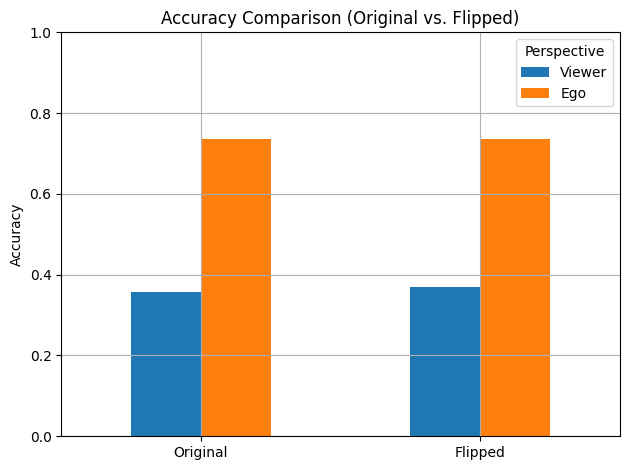

In [ ]:
plot_accuracy_comparison(df_vc_llava, df_ego_llava)

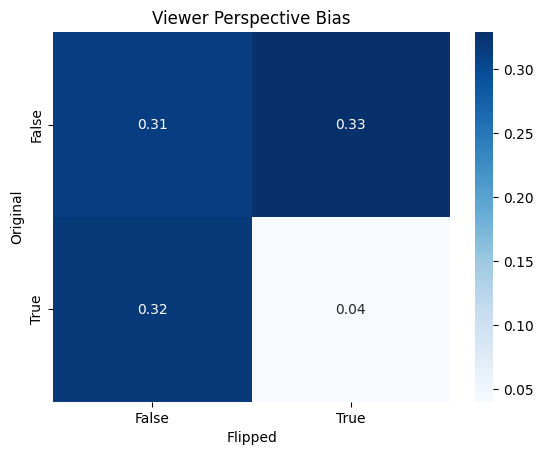

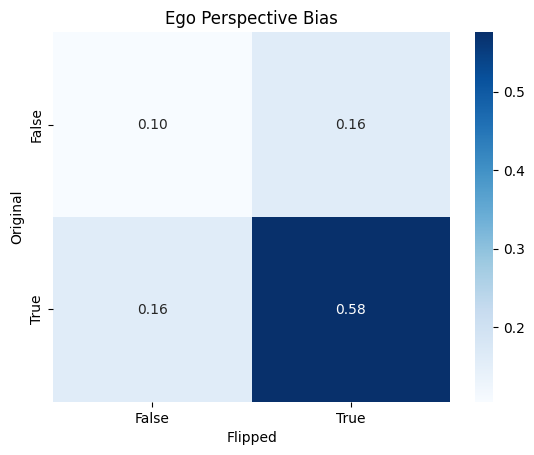

In [ ]:
plot_heatmap(df_vc_llava, 'Viewer Perspective Bias')
plot_heatmap(df_ego_llava, 'Ego Perspective Bias')

--- Viewer-Centric ---
Both correct (A): 40
Original correct only (B): 318
Flipped correct only (C): 329
Both wrong (D): 313
Symmetry Bias Score (B - C): -11



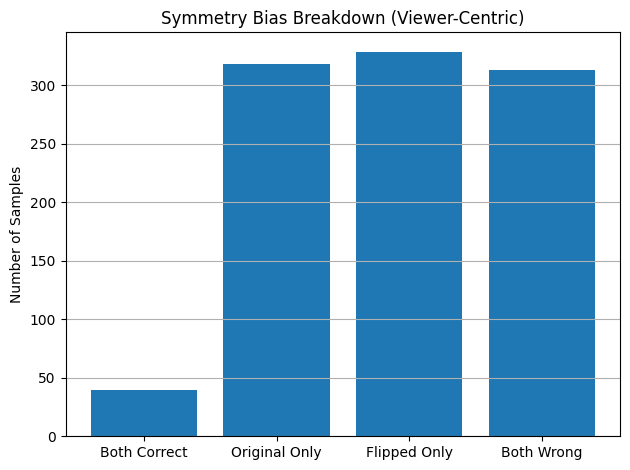

--- Ego-Centric ---
Both correct (A): 576
Original correct only (B): 159
Flipped correct only (C): 160
Both wrong (D): 105
Symmetry Bias Score (B - C): -1



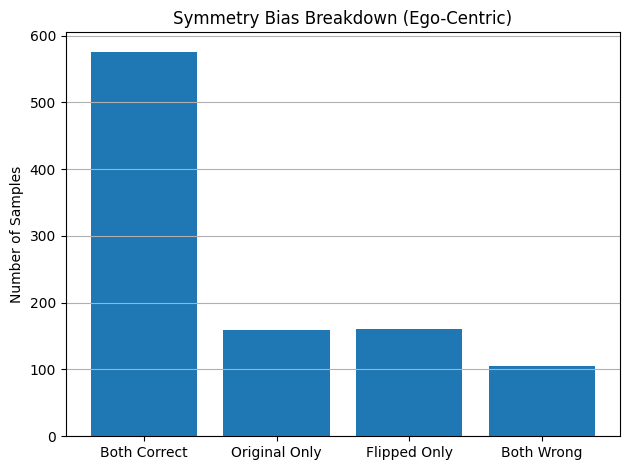

In [ ]:
symmetry_bias_analysis(df_vc_llava, 'Viewer-Centric')
symmetry_bias_analysis(df_ego_llava, 'Ego-Centric')

In [ ]:
# Egocentric vs Viewer Centric plots
ego_gpt4o_csv = 'gpt4o_sym_ego.csv'
vc_gpt4o_csv = 'gpt4o_sym_vc.csv'

df_ego_gpt4o = pd.read_csv(ego_llava_csv)
df_vc_gpt4o = pd.read_csv(vc_llava_csv)
df_ego_gpt4o = df_ego_gpt4o.iloc[:500].reset_index(drop=True)
df_vc_gpt4o = df_vc_gpt4o.iloc[:500].reset_index(drop=True)

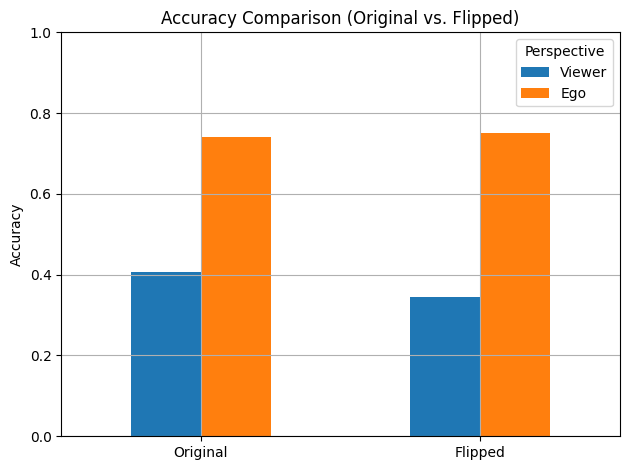

In [ ]:
plot_accuracy_comparison(df_vc_gpt4o, df_ego_gpt4o)

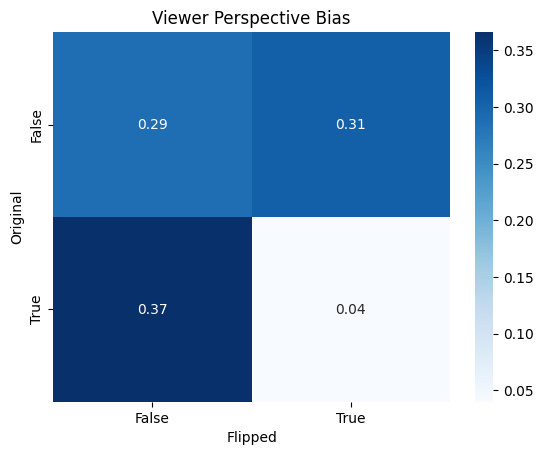

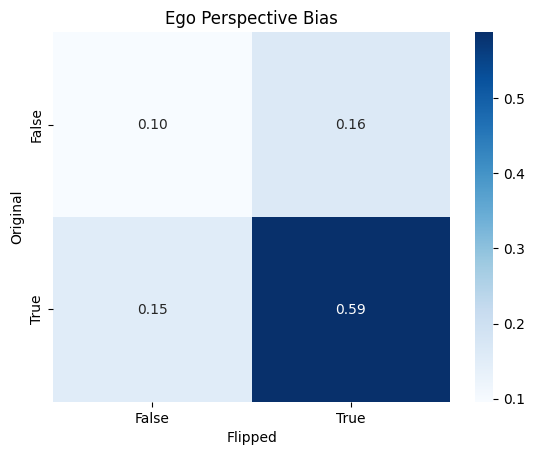

In [ ]:
plot_heatmap(df_vc_gpt4o, 'Viewer Perspective Bias')
plot_heatmap(df_ego_gpt4o, 'Ego Perspective Bias')

--- Viewer-Centric ---
Both correct (A): 20
Original correct only (B): 183
Flipped correct only (C): 153
Both wrong (D): 144
Symmetry Bias Score (B - C): 30



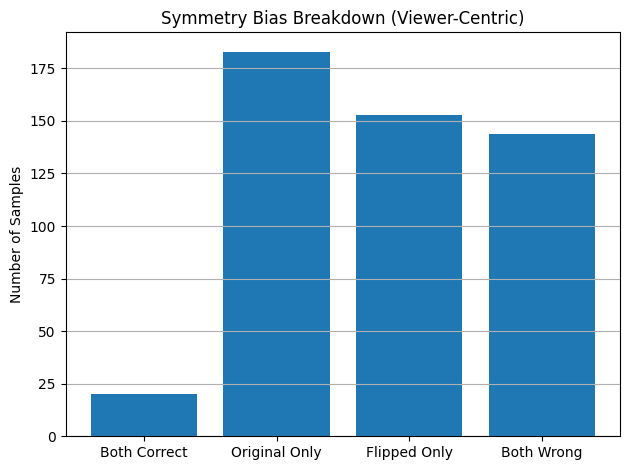

--- Ego-Centric ---
Both correct (A): 294
Original correct only (B): 76
Flipped correct only (C): 82
Both wrong (D): 48
Symmetry Bias Score (B - C): -6



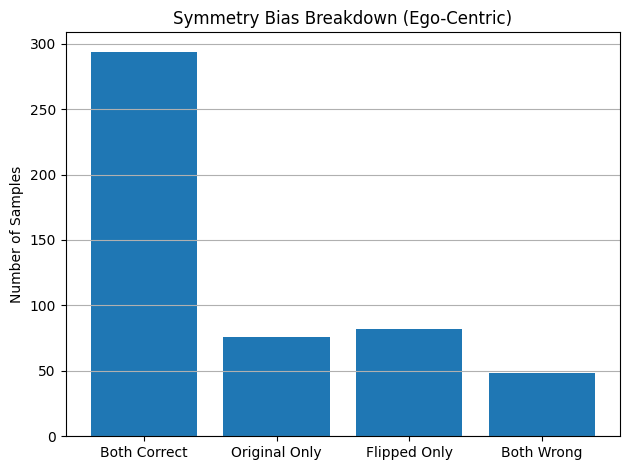

In [ ]:
symmetry_bias_analysis(df_vc_gpt4o, 'Viewer-Centric')
symmetry_bias_analysis(df_ego_gpt4o, 'Ego-Centric')

In [ ]:
def plot_model_accuracy_comparison(df_ego_llava, df_ego_gpt4o, df_vc_llava, df_vc_gpt4o):
    def compute_accuracy(df):
        return df['Original'].mean(), df['Flipped'].mean()

    # Build the DataFrame
    data = []
    for perspective, llava_df, gpt_df in [
        ("Ego", df_ego_llava, df_ego_gpt4o),
        ("Viewer", df_vc_llava, df_vc_gpt4o)
    ]:
        for model_name, model_df in [("LLaVA", llava_df), ("GPT-4o", gpt_df)]:
            acc_orig, acc_flip = compute_accuracy(model_df)
            data.append({
                "Condition": f"{perspective} / Original",
                "Model": model_name,
                "Accuracy": acc_orig
            })
            data.append({
                "Condition": f"{perspective} / Flipped",
                "Model": model_name,
                "Accuracy": acc_flip
            })

    plot_df = pd.DataFrame(data)

    # Set plot style
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))

    # Grouped bar plot with model hue
    ax = sns.barplot(
        data=plot_df,
        x="Condition",
        y="Accuracy",
        hue="Model",
        palette="Set2",
        errorbar=None
    )

    # Annotate each bar with its accuracy
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

    # Final styling
    plt.title("LLaVA vs GPT-4o Accuracy\n(Ego & Viewer, Original & Flipped)")
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.xlabel("Condition")
    plt.xticks(rotation=15)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


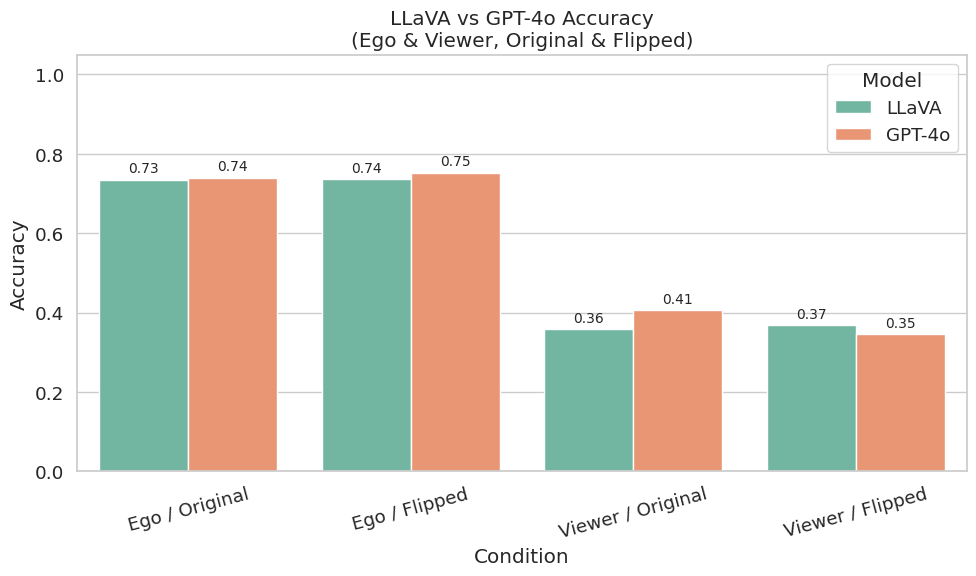

In [ ]:
plot_model_accuracy_comparison(df_ego_llava, df_ego_gpt4o, df_vc_llava, df_vc_gpt4o)

In [ ]:
def plot_model_accuracy_comparison2(df_ego_llava, df_ego_gpt4o, df_vc_llava, df_vc_gpt4o):
    def compute_accuracy(df):
        return df['Original'].mean(), df['Flipped'].mean()

    # Build the DataFrame
    data = []
    for perspective, llava_df, gpt_df in [
        ("Ego", df_ego_llava, df_ego_gpt4o),
        ("Viewer", df_vc_llava, df_vc_gpt4o)
    ]:
        for model_name, model_df in [("LLaVA", llava_df), ("GPT-4o", gpt_df)]:
            acc_orig, acc_flip = compute_accuracy(model_df)
            data.append({
                "Perspective": perspective,
                "Condition": "Original",
                "Model": model_name,
                "Accuracy": acc_orig
            })
            data.append({
                "Perspective": perspective,
                "Condition": "Flipped",
                "Model": model_name,
                "Accuracy": acc_flip
            })

    plot_df = pd.DataFrame(data)

    # Set up a professional-looking style
    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(12, 7))

    # Define a cleaner color palette
    colors = ["#3498db", "#e74c3c"]  # Blue and red

    # Create the grouped bar plot
    ax = sns.catplot(
        data=plot_df,
        x="Perspective",
        y="Accuracy",
        hue="Model",
        col="Condition",
        kind="bar",
        palette=colors,
        height=5,
        aspect=0.9,
        legend=False,
        alpha=0.9,
        edgecolor="white",
    )

    # Add value labels on top of each bar
    for axes in ax.axes.flat:
        for container in axes.containers:
            axes.bar_label(container, fmt="%.2f", padding=3, fontsize=11, fontweight='bold')

    # Customize title, labels and appearance
    ax.set_titles("{col_name}")
    ax.set_xlabels("Perspective")
    ax.set_ylabels("Accuracy")

    # Set y-axis limits with a bit of padding
    ax.set(ylim=(0, 1.05))

    # Add a title that spans the entire figure
    plt.suptitle("Model Accuracy Comparison: LLaVA vs. GPT-4o",
                fontsize=16, y=1.05, fontweight='bold')

    # Add a legend at the bottom
    plt.legend(title="Model", loc='upper center',
              bbox_to_anchor=(0, -0.15, 1, 0),
              ncol=2, frameon=True, fontsize=12)

    plt.tight_layout()
    plt.show()

<ipython-input-47-96f0489cbdb3>:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Model", loc='upper center',


<Figure size 1200x700 with 0 Axes>

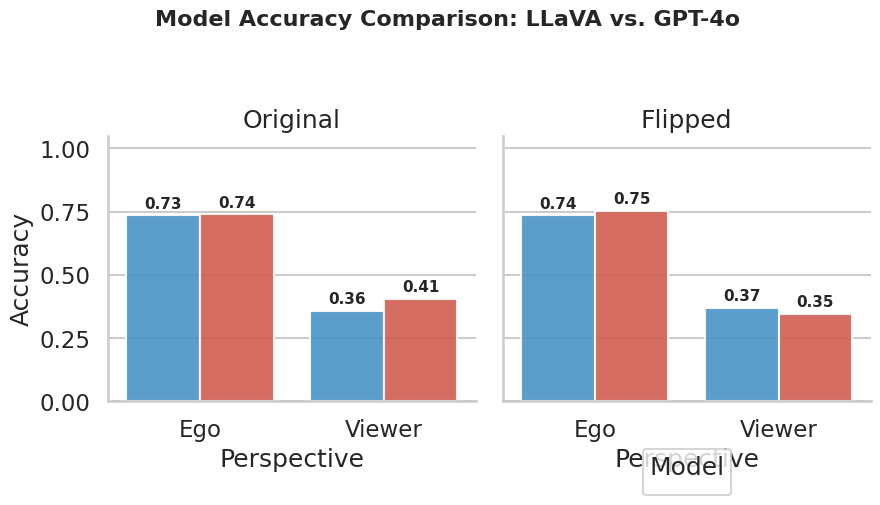

In [ ]:
plot_model_accuracy_comparison2(df_ego_llava, df_ego_gpt4o, df_vc_llava, df_vc_gpt4o)

# Final result Plots

In [ ]:
def evaluate_models(csv_folder):
    results = []

    for filename in sorted(os.listdir(csv_folder)):
        if filename.endswith(".csv"):
            # Parse model and view type from filename
            base_name = filename.replace(".csv", "")
            if "_" in base_name:
                model_name, view_type = base_name.split("_", 1)
            else:
                continue  # skip if file doesn't follow format

            # Load data
            df = pd.read_csv(os.path.join(csv_folder, filename))
            total = len(df)

            # Compute metrics
            original_accuracy = (df["Original"] == True).sum() / total * 100
            flipped_accuracy = (df["Flipped"] == True).sum() / total * 100
            consistency = (df["Original"] == df["Flipped"]).sum() / total * 100

            # Save results
            results.append({
                "Model": model_name,
                "View Type": view_type.replace("-", " ").title(),
                "Original Accuracy (%)": round(original_accuracy, 1),
                "Flipped Accuracy (%)": round(flipped_accuracy, 1),
                "Consistency (%)": round(consistency, 1)
            })

    return pd.DataFrame(results)


In [ ]:
# Example usage
csv_folder = '/content/drive/My Drive/GNLP/3_task/'
df_results = evaluate_models(csv_folder)
print(df_results)

    Model    View Type  Original Accuracy (%)  Flipped Accuracy (%)  \
0  claude      Sym_Ego                   72.2                  71.9   
1  claude       Sym_Vc                   25.2                  26.0   
2   gpt4o      Sym_Ego                   59.6                  59.4   
3   gpt4o       Sym_Vc                   30.7                  28.3   
4   llava  13B_Sym_Ego                   72.2                  72.6   
5   llava   13B_Sym_Vc                   34.3                  35.2   
6   llava   7B_Sym_Ego                   73.5                  73.6   
7   llava    7B_Sym_Vc                   35.8                  36.9   

   Consistency (%)  
0             63.7  
1             61.6  
2             45.8  
3             49.8  
4             74.6  
5             34.5  
6             68.1  
7             35.3  


In [ ]:
import pandas as pd
import os

def generate_latex_symmetry_table(csv_folder):
    rows = []

    for filename in sorted(os.listdir(csv_folder)):
        if filename.endswith(".csv"):
            filepath = os.path.join(csv_folder, filename)
            df = pd.read_csv(filepath)
            total = len(df)

            original_acc = (df["Original"] == True).sum() / total * 100
            flipped_acc = (df["Flipped"] == True).sum() / total * 100
            consistency = (df["Original"] == df["Flipped"]).sum() / total * 100

            # Use full filename as model name (as requested)
            rows.append(f"{filename} & {original_acc:.1f} & {flipped_acc:.1f} & {consistency:.1f} \\\\")

    # Create full LaTeX table
    latex_table = r"""
\begin{table*}[t]
\centering
\small
\begin{tabular}{lccc}
\hline
\textbf{CSV File} & \textbf{Original Accuracy (\%)} & \textbf{Flipped Accuracy (\%)} & \textbf{Consistency (\%)} \\
\hline
""" + "\n".join(rows) + r"""
\hline
\end{tabular}
\caption{
Evaluation of each CSV file on the left–right spatial reasoning task. Each file represents a model and view type combination.
}
\label{tab:symmetry-results}
\end{table*}
"""
    return latex_table


In [ ]:
csv_folder = '/content/drive/My Drive/GNLP/3_task/'

latex_code = generate_latex_symmetry_table(csv_folder)
print(latex_code)  # or write to a .tex file



\begin{table*}[t]
\centering
\small
\begin{tabular}{lccc}
\hline
\textbf{CSV File} & \textbf{Original Accuracy (\%)} & \textbf{Flipped Accuracy (\%)} & \textbf{Consistency (\%)} \\
\hline
claude_sym_ego.csv & 72.2 & 71.9 & 63.7 \\
claude_sym_vc.csv & 25.2 & 26.0 & 61.6 \\
gpt4o_sym_ego.csv & 59.6 & 59.4 & 45.8 \\
gpt4o_sym_vc.csv & 30.7 & 28.3 & 49.8 \\
llava_13b_sym_ego.csv & 72.2 & 72.6 & 74.6 \\
llava_13b_sym_vc.csv & 34.3 & 35.2 & 34.5 \\
llava_7b_sym_ego.csv & 73.5 & 73.6 & 68.1 \\
llava_7b_sym_vc.csv & 35.8 & 36.9 & 35.3 \\
\hline
\end{tabular}
\caption{
Evaluation of each CSV file on the left–right spatial reasoning task. Each file represents a model and view type combination.
}
\label{tab:symmetry-results}
\end{table*}



In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def parse_model_and_view(filename):
    # Example: "llava_7b_sym_ego.csv"
    base = filename.replace(".csv", "")
    parts = base.split("_sym_")
    model = parts[0]
    view_code = parts[1]
    view = "Egocentric" if view_code == "ego" else "Viewer Centric"
    return model, view

def load_accuracy_data(csv_folder):
    data = []

    for filename in sorted(os.listdir(csv_folder)):
        if not filename.endswith(".csv"):
            continue

        model, view = parse_model_and_view(filename)
        df = pd.read_csv(os.path.join(csv_folder, filename))
        total = len(df)

        original_acc = (df["Original"] == True).sum() / total * 100
        flipped_acc = (df["Flipped"] == True).sum() / total * 100
        consistency = (df["Original"] == df["Flipped"]).sum() / total * 100

        data.append({
            "Model": model,
            "View": view,
            "Original Accuracy": original_acc,
            "Flipped Accuracy": flipped_acc,
            "Consistency": consistency
        })

    return pd.DataFrame(data)

def plot_accuracy_comparison(df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Model", y="Original Accuracy", hue="View")
    plt.ylim(0, 100)
    plt.title("Original Accuracy by Model and View Type")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.legend(title="View Type")
    plt.tight_layout()
    plt.show()

# Example usage:
# df_results = load_accuracy_data("path/to/csv/folder")
# plot_accuracy_comparison(df_results)


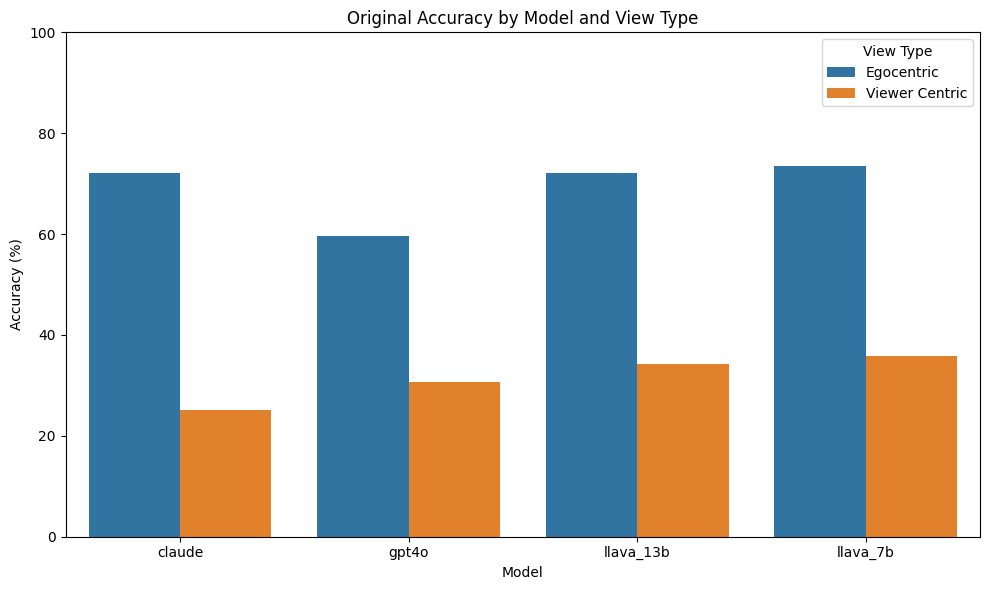

In [ ]:
csv_folder = '/content/drive/My Drive/GNLP/3_task/'
df_results = load_accuracy_data(csv_folder)
plot_accuracy_comparison(df_results)

In [ ]:
# Symmetry detection
import pandas as pd

def compute_symmetry_detection_accuracy(csv_files, model_names):
    """
    Given a list of CSV files and corresponding model names, returns a DataFrame
    with accuracy for 'Normal' and 'Symmetrical' image symmetry detection.

    Each CSV must contain:
    - 'Normal' column: 1 if the model correctly said "not symmetrical"
    - 'Symmetrical' column: 1 if the model correctly said "symmetrical"
    """
    results = []

    for csv_file, model in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)

        normal_acc = df["Normal"].mean() * 100
        symmetrical_acc = df["Symmetrical"].mean() * 100

        results.append({
            "Model": model,
            "Image Type": "Normal (Non-Symmetrical)",
            "Accuracy (%)": round(normal_acc, 1)
        })
        results.append({
            "Model": model,
            "Image Type": "Symmetrical",
            "Accuracy (%)": round(symmetrical_acc, 1)
        })

    return pd.DataFrame(results)


In [ ]:
csv_files = ['llava_7b_symmetry_detection.csv', 'llava_13b_symmetry_detection.csv']
model_names = ['LLaVA 7B', 'LLaVA 13B']

df_symmetry_detection = compute_symmetry_detection_accuracy(csv_files, model_names)
print(df_symmetry_detection)

       Model                Image Type  Accuracy (%)
0   LLaVA 7B  Normal (Non-Symmetrical)          20.2
1   LLaVA 7B               Symmetrical         100.0
2  LLaVA 13B  Normal (Non-Symmetrical)          47.6
3  LLaVA 13B               Symmetrical         100.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_symmetry_detection_accuracy(df):
    """
    Plots grouped bar chart with accuracy per model and image type,
    with larger text and value labels (excluding 100% to avoid overlap).
    """
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x="Model",
        y="Accuracy (%)",
        hue="Image Type",
        palette="Set2"
    )

    # Add labels only if value < 100
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height < 100:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 1,
                    f"{height:.1f}",
                    ha="center",
                    va="bottom",
                    fontsize=11
                )

    plt.title("Symmetry Detection Accuracy by Model", fontsize=17)
    plt.ylim(0, 105)
    plt.xlabel("Model", fontsize=15)
    plt.ylabel("Accuracy (%)", fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(title="Image Type", title_fontsize=14, fontsize=13)
    plt.tight_layout()
    plt.show()


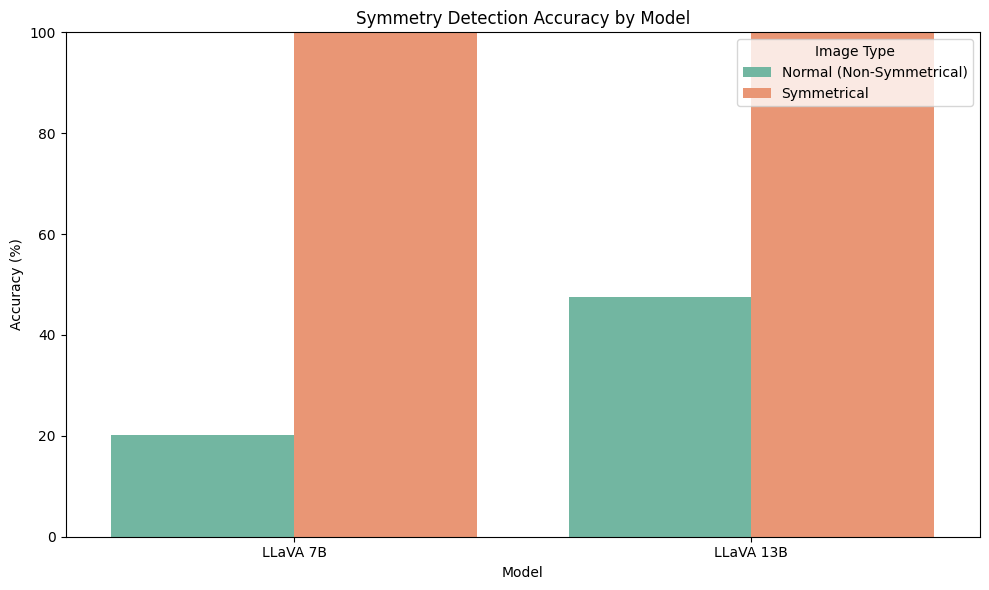

In [ ]:
plot_symmetry_detection_accuracy(df_symmetry_detection)

In [ ]:
new_model_data = pd.DataFrame([
    {"Model": "Claude-3.5 Sonnet", "Image Type": "Normal (Non-Symmetrical)", "Accuracy (%)": 42.3},
    {"Model": "Claude-3.5 Sonnet", "Image Type": "Symmetrical", "Accuracy (%)": 100}
])

df_combined = pd.concat([df_symmetry_detection, new_model_data], ignore_index=True)

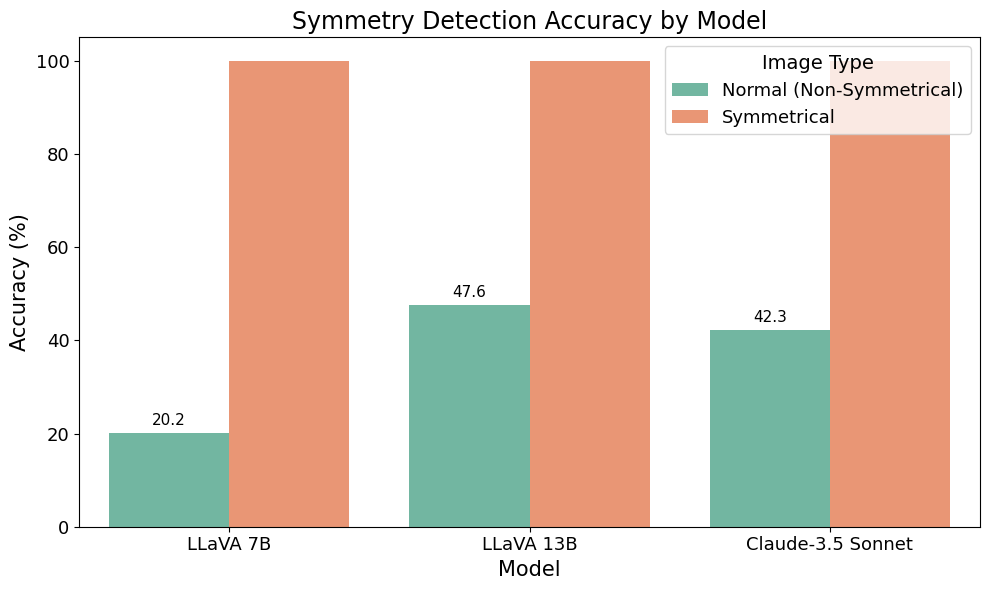

In [ ]:
plot_symmetry_detection_accuracy(df_combined)

In [ ]:
import pandas as pd

def summarize_object_list_metrics(csv_files, model_names):
    """
    Summarize object detection consistency metrics from CSVs.

    Each CSV should have:
    - '#Objects_Original'
    - '#Objects_Flipped'
    - '#Shared'
    - 'Jaccard'
    - 'Exact match' (boolean)

    Returns a DataFrame with averaged values per model.
    """
    results = []

    for file, model in zip(csv_files, model_names):
        df = pd.read_csv(file)

        avg_orig = df['#Objects_Original'].mean()
        avg_flip = df['#Objects_Flipped'].mean()
        avg_shared = df['#Shared'].mean()
        avg_jaccard = df['Jaccard'].mean()
        ratio_shared_orig = (df['#Shared'] / df['#Objects_Original'].replace(0, 1)).mean()
        exact_match_pct = df['ExactMatch'].mean() * 100  # percentage

        results.append({
            "Model": model,
            "Avg #Objects (Original)": round(avg_orig, 2),
            "Avg #Objects (Flipped)": round(avg_flip, 2),
            "Avg #Shared": round(avg_shared, 2),
            "Avg Jaccard": round(avg_jaccard, 3),
            "Shared/Original Ratio": round(ratio_shared_orig, 3),
            "Exact Match (%)": round(exact_match_pct, 1)
        })

    return pd.DataFrame(results)


In [ ]:
def df_to_latex_table(df, caption="Object list consistency across flipped images", label="tab:object_list_results"):
    return df.to_latex(index=False, caption=caption, label=label, column_format="lcccccc")


In [ ]:
csv_files = ['llava_7b_flip_obj_list.csv', 'llava_13b_flip_obj_list.csv', 'gpt4o_flip_obj_list.csv']
model_names = ['LLaVA 7B', 'LLaVA 13B', 'GPT-4o']
df_results = summarize_object_list_metrics(csv_files, model_names)

In [ ]:
latex_code = df_to_latex_table(df_results)
print(latex_code)

\begin{table}
\caption{Object list consistency across flipped images}
\label{tab:object_list_results}
\begin{tabular}{lcccccc}
\toprule
Model & Avg #Objects (Original) & Avg #Objects (Flipped) & Avg #Shared & Avg Jaccard & Shared/Original Ratio & Exact Match (%) \\
\midrule
LLaVA 7B & 7.070000 & 6.810000 & 3.640000 & 0.470000 & 0.603000 & 14.200000 \\
LLaVA 13B & 3.020000 & 2.610000 & 1.720000 & 0.660000 & 0.450000 & 47.100000 \\
GPT-4o & 6.790000 & 6.890000 & 3.890000 & 0.469000 & 0.614000 & 7.900000 \\
\bottomrule
\end{tabular}
\end{table}

